### 1. Load feature vectors from dataset

In [23]:
import os
import cv2
from detection import detect_face_for_testing
from feature_extraction import extract_feature, init_facenet

DATASET_PATH = "test_images_LFW_entire"
REF_IMG_INDEX = 0 # The index for the reference images in a particular dataset
                   # FEI -> 11
                   # LFW -> 0
                   # GT  -> 0

recognition_model = init_facenet()

ref_feat_vect_dict = {} # Dictionary to store the reference feature vector for each person
feat_vect_dict = {} # Dictionary to store the rest of the feature vectors for each person

#j = 0

for person in os.listdir(DATASET_PATH):
    person_path = os.path.join(DATASET_PATH, person)

    feat_vect_dict[person] = []

    #j += 1

    for i, img_name in enumerate(os.listdir(person_path)):
        img_path = os.path.join(person_path, img_name)
        img_array = cv2.imread(img_path)
        face_data, _, image_rgb = detect_face_for_testing(img_array)
        
        if face_data is not None:
            feature_vector = extract_feature(face_data, image_rgb, recognition_model)

            if feature_vector is None:
                continue

            if i == REF_IMG_INDEX:
                ref_feat_vect_dict[person] = feature_vector # Add reference feature vector to its corresponding person
            else:
                feat_vect_dict[person].append(feature_vector) # Add feature vector to its corresponding person
        else:
            print("No face detected")
            
    #if j > 10: # To ensure not loading the entire dataset when testing the basic test functionality
    #    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━

### 2. Create test cases

In [48]:
import random
from itertools import combinations

# Create positive test for each person cases by matching the reference image with each of the other images
pos_test_cases = []

for person, feature_vectors in feat_vect_dict.items():
    ref_feat_vect = ref_feat_vect_dict.get(person)

    if ref_feat_vect is None:
        continue

    for i in range(len(feature_vectors)):
        feat_vect = feature_vectors[i]
        pos_test_cases.append((ref_feat_vect, feat_vect, True, person, person)) # Add test case consisting of the feature vectors that are to be compared and the expected value

# Create negative tests by randomly matching non-identical reference images. Should constitute 20% of the total test cases
num_of_neg_tests = int(len(pos_test_cases)/4)

neg_pairs = list(combinations(ref_feat_vect_dict.items(), 2))
neg_pairs = neg_pairs[:num_of_neg_tests]
neg_test_cases = [(ref_feat_vect1, ref_feat_vect2, False, person1, person2) for (person1, ref_feat_vect1), (person2, ref_feat_vect2) in neg_pairs]
random.shuffle(neg_test_cases)

# Combine the test cases
all_test_cases = pos_test_cases + neg_test_cases



### 3. Functions used to evaluate the test cases and visualize the results

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from verification import compare_faces_euclidean
import numpy as np

VERIFICATION_THRESHOLDS = np.arange(0.1, 2.1, 0.1) # Used for comparing the likeness of two feature vectors

def run_test(y_true, threshold):
    y_pred = []

    # Test the verification functionality on each test case pair 
    for f_vect_1, f_vect_2, has_same_face, p1, p2 in all_test_cases:
        prediction = compare_faces_euclidean(f_vect_1, f_vect_2, threshold=threshold) #prediction, distance = compare_faces_euclidean(f_vect_1, f_vect_2)
        y_pred.append(prediction)
        if prediction == has_same_face:
            pass
        else:
            #print(f'Incorrect prediction for persons {p1} and {p2}')
            pass

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"For treshold: {threshold}\nAccuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}\n")

    return y_pred


def plot_conf_mat(y_true, threshold):
    y_pred = run_test(y_true, threshold)
    conf_mat = confusion_matrix(y_true, y_pred)

    # Plotting the confusion matrix
    conf_mat_display = ConfusionMatrixDisplay(conf_mat)
    conf_mat_display.plot()
    
    # Labels
    plt.xlabel("Predicted Value")
    plt.ylabel("True Value")

    plt.show()

def get_tpr_and_fpr(y_true, y_pred):
    conf_mat = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_mat.ravel()

    tpr = tp / (tp + fn)  # True positive rate
    fpr = fp / (fp + tn)  # False positive rate

    return tpr, fpr

def plot_ROC(y_true):
    tpr_list = []
    fpr_list = []

    for threshold in VERIFICATION_THRESHOLDS:
        y_pred = run_test(y_true, threshold)
        
        tpr, fpr = get_tpr_and_fpr(y_true, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    plt.figure(figsize=(5.43, 4.65)) 

    # Plotting the ROC curve
    plt.plot(fpr_list, tpr_list, marker='o', linestyle='-', label='ROC Curve', alpha=0.7, markersize=8)

    # Plotting the diagonal (random guess line)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Diagonal line from (0, 0) to (1, 1)

    # Annotate first, middle and last point with the corresponding threshold value
    for i in [0, (len(fpr_list) // 2) - 1, len(fpr_list) - 1]:  
        plt.text(fpr_list[i], tpr_list[i], str(round(VERIFICATION_THRESHOLDS[i], 1)), 
                fontsize=9, ha='right', va='bottom', color='red')

    # Labels and legend
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend()

    plt.show()




### 4. Plot the ROC curve to find suitable thresholds

c:\Users\erikg\anaconda3\envs\deep\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


For treshold: 0.1
Accuracy: 0.2000, Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000

For treshold: 0.2
Accuracy: 0.2001, Precision: 1.0000, Recall: 0.0001, F1-score: 0.0003

For treshold: 0.30000000000000004
Accuracy: 0.2015, Precision: 1.0000, Recall: 0.0019, F1-score: 0.0038

For treshold: 0.4
Accuracy: 0.2124, Precision: 1.0000, Recall: 0.0155, F1-score: 0.0305

For treshold: 0.5
Accuracy: 0.2664, Precision: 1.0000, Recall: 0.0830, F1-score: 0.1533

For treshold: 0.6
Accuracy: 0.4217, Precision: 1.0000, Recall: 0.2771, F1-score: 0.4340

For treshold: 0.7000000000000001
Accuracy: 0.6357, Precision: 1.0000, Recall: 0.5446, F1-score: 0.7052

For treshold: 0.8
Accuracy: 0.8091, Precision: 1.0000, Recall: 0.7614, F1-score: 0.8645

For treshold: 0.9
Accuracy: 0.9150, Precision: 1.0000, Recall: 0.8938, F1-score: 0.9439

For treshold: 1.0
Accuracy: 0.9691, Precision: 0.9999, Recall: 0.9615, F1-score: 0.9803

For treshold: 1.1
Accuracy: 0.9853, Precision: 0.9970, Recall: 0.9847, F1-score

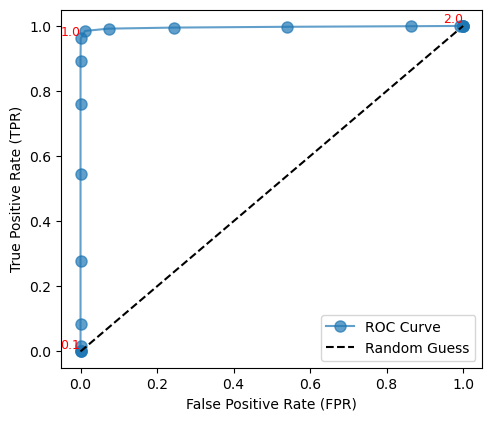

In [52]:
y_true = [test_case[2] for test_case in all_test_cases] # Create list consisting of the correct classifiers

plot_ROC(y_true)

### 5. Plot the confusion matrix

For treshold: 0.8
Accuracy: 0.8091, Precision: 1.0000, Recall: 0.7614, F1-score: 0.8645



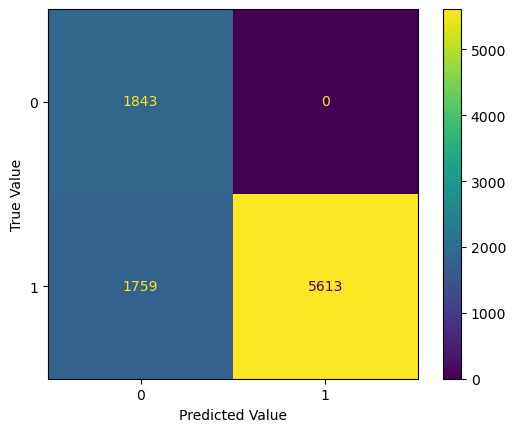

In [59]:
threshold = 0.8 # The best threshold value according to the ROC curve above

plot_conf_mat(y_true, threshold)